## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import skimage.measure
import numpy as np
import gym
from gym import wrappers

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Preprocessing

In [2]:
class Preprocess:
    
    def __init__(self, data):
        self.data_ = data
        
    def get_data(self, data):
        self.data_ = data
        
    def crop(self, h_start=30, h_end=194):
        self.data_ = self.data_[h_start:h_end, ::]
        
    def rgb2gray(self):
        self.data_ = np.dot(self.data_, [0.2989, 0.5870, 0.1140])
        
    def downsample(self, kernel=2):
        self.data_ = skimage.measure.block_reduce(self.data_, (kernel, kernel), np.max)

## Experience Replay

In [3]:
class ExperienceReplay:
    
    dq_ = deque(maxlen=32)

    def __init__(self, C, experience_tuple):
        self.capacity_ = C
        self.exp_tuple_ = experience_tuple
        self.dq_.append(experience_tuple)
        
    def add_experience(self, experience_tuple):
        '''add new experience'''
        self.dq_.append(experience_tuple)
    
    def sample(self, capacity):
        '''sample from experience'''
        nb_items = len(self.dq_)
        if nb_items > capacity:
            idx = np.random.choice( nb_items, size=capacity, replace=False)
        else:
            idx = np.random.choice( nb_items, size=nb_items, replace=False)
        return [self.dq_[i] for i in idx]

## Epsilon Generator

In [4]:
class EpsilonGenerator():
    
    def __init__(self, start, stop, steps):
        self.epsilon_ = start
        self.stop_ = stop
        self.steps_ = steps
        self.step_size_ = (self.epsilon_ - stop) / (self.steps_)
        self.count_ = 0
        
    def epsilon_update(self):
        if self.count_ == 0:
            self.count_ += 1
            return self.epsilon_
        elif (self.epsilon_ >= self.stop_ and self.count_ < self.steps_):
            self.count_ += 1
            self.epsilon_ -= self.step_size_
        else:
            self.epsilon_ = self.stop_
            self.count_ += 1

## CNN Architecture

In [5]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 4)  ## Conv2d(nChannels, filters, kernel, stride)
        self.conv2 = nn.Conv2d(16, 32, 4, 4)
        self.fc1 = nn.Linear(32 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 4 * 4)  ## reshape 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [6]:
num_games = 1  ## number of games to play
time_steps = 100  ## max number of time steps per game
record = 0

In [7]:
env = gym.make('Breakout-v0')
if record:
    env = wrappers.Monitor(env, 
                           directory='/Users/davidziganto/Data_Science/PyTorch/OpenAI_vids/breakout-experiment-1', 
                           video_callable=None, ## takes video when episode number is perfect cube
                           force=True)

# setup for CNN
cnn = CNN()
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.RMSprop(cnn.parameters(), 
                          lr=learning_rate, 
                          alpha=0.99, 
                          eps=1e-08, 
                          weight_decay=0, 
                          momentum=0, 
                          centered=False)

# variables
discount = 0.9  ## on future rewards

# play game
for episode in range(num_games):
    
    ## reset environment
    initial_seq = Preprocess(env.reset())

    # preprocess initial sequence
    initial_seq.crop()
    initial_seq.rgb2gray()
    initial_seq.downsample()
    
    for t in range(time_steps):
        
        ## show game in real-time
        env.render()
        
        # take action (0=do nothing; 1=fire ball; 2=move right; 3=move left)
        if t == 0:
            action = 1
        else:
            if t % 4 == 0:
                action = env.action_space.sample()
        
        # get feedback
        observation, reward, done, info = env.step(action)
        
env.close()

[2017-08-28 16:29:46,398] Making new env: Breakout-v0


## Stats for 1000 games taking random actions

In [30]:
env = gym.make('Breakout-v0')

rewards = []
steps = []

for game in range(1000):
    
    myreward = 0
    
    # reset game
    env.reset()
    
    for t in range(1000):
        
        # show in real-time
        #env.render()
        
        # take a random action
        if t == 0:
            action = 1
        else:
            action = env.action_space.sample() 
        
        # get feedback
        observation, reward, done, info = env.step(action)
        myreward += reward
        
        # end game when out of balls
        if done:
            rewards.append(myreward)
            steps.append(t)
            stats = zip(steps, rewards)
            env.close()
            break

[2017-08-28 16:47:04,100] Making new env: Breakout-v0


In [33]:
max(rewards)

9.0

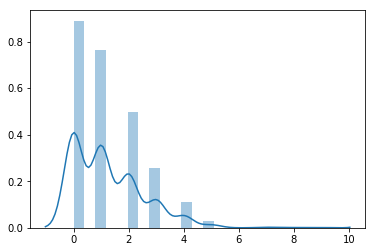

In [31]:
import seaborn as sns
sns.distplot(rewards);

In [ ]:
    for t in range(time_steps):
        
        # show game in real-time
        #env.render()
        
        # linearly anneal epsilon (prob of selecting random action)
        if anneal_tracker <= anneal_stop:
            epsilon = next(gen_epsilon)
        ##print('epsilon:', epsilon)
        anneal_tracker += 1
        
        # take agent-based action every 4 time steps; otherwise push action forward w/out agent computing
        if t%4 == 0:
            # feedforward for agent-based action
            sample_frame = Variable(torch.Tensor(seq_init).unsqueeze(0).unsqueeze(0))  ## setup for CNN (unsqueeze to fake 4D tensor since single observation)
            action_decision = cnn(sample_frame)  ## return optimal action 
            ##print(action_decision)
            # take epsilon-greedy action (prob(epsilon) = random; else argmax(action))
            #action = env.action_space.sample() if np.random.binomial(n=1, p=epsilon, size=1) else action_decision.data.max(1)[1][0]
            if np.random.binomial(n=1, p=epsilon, size=1):
                action = env.action_space.sample()
            else: 
                checker += 1
                action = action_decision.data.max(1)[1][0]
            #print('action =', action)
        
        # gather feedback from emulator
        observation, reward, done, info = env.step(action)
        score += reward
        
        # preprocess new observation post action    
        seq_update = preprocess(observation)
        
        # mini-batch setup
        if t%4 == 3 or done:
            ##print(t)
            frames.append(seq_update)
            ## makes arrays callable to feed into CNN
            frameTensor = np.stack(frames)  
            ## convert Numpy Array --> PyTorch Tensor --> PyTorch Variable
            frameTensor = Variable(torch.Tensor(frameTensor))  
            ##print('t:', t, '\n', frameTensor)  ## should be 4x82x80 unless 'done'
            ## clear mini-batch
            frames = []  
        else:
            frames.append(seq_update)
        
        # stop if out of lives
        if done:
            gamestatus = 'terminal'
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            ##print('*step: ', t, '| gamestatus: ', gamestatus, '| len(D):', len(D), 
            ##      '| init != update:', (D[len(D)-1][0] != D[len(D)-1][3]).sum())
            print('steps:', t, '| episode:', episode, '| score:', score, '| checker:', checker)
            break
        else:
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            ##print('step:', t, '| gamestatus:', gamestatus, '| action:', action, '| len(D):', len(D), 
            ##      '| init != update:',(D[len(D)-1][0] != D[len(D)-1][3]).sum())
    
        
        # mini-batch sample of experience replay for ConvNet
        D_size = len(D)
        idx = np.random.choice(range(D_size), size=min(D_size, 32), replace=False)
        ## empty list to capture mini-batch of D
        minibatch_D = []
        # calculate target
        for i in idx:
            minibatch_D.append(D[i])
            #print('step: ', i, 'gamestatus: ', D[4], 'reward: ', D[2]) 
            
        # create dataset
        data_list = [D[i][0] for i in range(D_size)]
        data = Variable(torch.Tensor(data_list).unsqueeze(1))
        ##print(data)
        
        # create target variable
        target_list = []
        for i in range(D_size):
            if D[i][4] == 'terminal':
                target_list.append(D[i][2])
            else:
                target_list.append(D[i][2] + discount * 
                                   cnn(Variable(torch.Tensor(D[i][3]).unsqueeze(0).unsqueeze(0))).data.max(1)[1][0])
        targets = Variable(torch.Tensor(target_list))
        ##print(targets)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # feedforward pass
        outputs = cnn(data).max(1)[0]
        ##print(outputs)
        
        # calculate loss
        loss = criterion(outputs, targets)
        #print('loss:', loss)
        
        # backprop
        loss.backward()
        
        # update network weights
        optimizer.step()
        
        # set new observation as initial sequence
        seq_init = seq_update
        
        # print statistics
        #running_loss += loss.data[0]
        #if t % 200 == 199:    # print every 200 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (episode + 1, t + 1, running_loss / 200))
        #    running_loss = 0.0
        

In [ ]:
# check how many times DQN chose action as opposed to random action
checker

In [ ]:
# ensure minibatch of experience replay doesn't exceed 32
len(minibatch_D)

#### Save Model

In [ ]:
torch.save(cnn.state_dict(), '/Users/davidziganto/Data_Science/PyTorch/DL_models/DL_RL_Atari_breakout_500e_10000t')

#### Load Model

In [ ]:
#cnn = CNN()
#cnn.load_state_dict(torch.load('/Users/davidziganto/Data_Science/PyTorch/DL_models/DL_RL_Atari_breakout'))

# EXAMPLE

### Get Frames

In [ ]:
frames = []
rewards = []
nb_frames = 500
env = gym.make('Breakout-v0')
env.reset()
for t in range(nb_frames):
    env.render()
    action = env.action_space.sample() # take a random action
    observation, reward, done, info = env.step(action)
    frames.append(preprocess(observation))
    if t%4 == 3 or done:
        frameTensor = np.stack(frames)
        minibatch = Variable(torch.Tensor(frameTensor))  ## convert to torch Variable data type
        print('t:', t, '\n', minibatch)
        frames = []
    if done:
        break

### Show Preprocessed Data Frames

In [ ]:
for frame in frames:
    plt.imshow(frame, cmap = plt.get_cmap('gray'))
    plt.show()

### Frame Dimensions

In [ ]:
frame.shape

# EXPERIMENTAL

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
net.conv1

In [ ]:
net.conv2

In [ ]:
net.fc1

In [ ]:
net.fc2

In [ ]:
net.fc3

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
outputs

In [ ]:
labels

# Legacy

In [ ]:
#1

# Atari emulator
env = gym.make('Breakout-v0')

# game variables
nb_games = 5  ## number of games to play
time_steps = 500  ## max number of time steps per game

# experience replay variables
N = int(1e6)  ## capacity
D = deque()  ## deque object

# RL vars
anneal_tracker = 0  ## tally of how many total iterations have passed
anneal_stop = 1000  ## nb of steps until annealing stops
gen_epsilon = epsilon_generator(start=1, stop=0.1, num=anneal_stop)  ## Prob(choosing random action) w/linear annealing
discount = 0.9  ## on future rewards

# CNN setup
cnn = CNN()
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.RMSprop(cnn.params, 
                          lr=learning_rate, 
                          alpha=0.99, 
                          eps=1e-08, 
                          weight_decay=0, 
                          momentum=0, 
                          centered=False)

# algorithm
for episode in range(nb_games):
    gamestatus = 'nonterminal'
    raw_frame = env.reset()  ## raw initial frame
    seq_init = preprocess(raw_frame)  ## preprocessed initial sequence 
    
    for t in range(time_steps):
        
        # show game in real-time
        env.render()
        
        # linearly anneal epsilon (prob of selecting random action)
        if anneal_tracker <= anneal_stop:
            epsilon = next(gen_epsilon)
        print('epsilon:', epsilon)
        anneal_tracker += 1
        
        # take agent-based action every 4 time steps; otherwise push action forward w/out agent computing
        if t%4 == 0:
            action = env.action_space.sample() # take a random action
            #action = env.action_space.sample() if np.random.binomial(n=1, p=epsilon, size=1) else action w/max Q-value
            #print('action =', action)
        
        # feedback from emulator
        observation, reward, done, info = env.step(action)
        
        # preprocess new observation after action    
        seq_update = preprocess(observation)
        
        # stop if out of lives
        if done:
            gamestatus = 'terminal'
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('*step: ', t, '| gamestatus: ', gamestatus, '| len(D):', len(D), 
                  '| init != update:', (D[len(D)-1][0] != D[len(D)-1][3]).sum())
            break
        else:
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('step:', t, '| gamestatus:', gamestatus, '| len(D):', len(D), 
                  '| init != update:',(D[len(D)-1][0] != D[len(D)-1][3]).sum())
    
        
        # mini-batch sample of experience replay for ConvNet
        D_size = len(D)
        idx = np.random.choice(range(D_size), size=min(D_size, 32), replace=False)
        # calculate target
        for i in idx:
            if D[i][4] == 'terminal':
                target = D[i][2] + 100
            else:
                #target = sample[i][2] + discount*(to be completed)
                target = D[i][2]
            #print('step: ', i, 'gamestatus: ', D[4], 'reward: ', D[2])
        # SGD update
        #update weights
        # set new observation as initial sequence
        seq_init = seq_update
        #print('final target =', target)
    #print( (D[len(D)-1][0] != D[len(D)-1][3]).sum())
    #print(D)

In [ ]:
# 2

for episode in range(nb_games):
    ## setup to check loss per episode
    running_loss = 0.0
    ## empty list to capture mini-batch of frames
    frames = []  
    ## default status to differentiate rewards (aka targets)
    gamestatus = 'nonterminal'  
    ## raw frame of game start
    raw_frame = env.reset()  
    ## preprocessed initial frame 
    seq_init = preprocess(raw_frame)  
    
    for t in range(time_steps):
        
        # show game in real-time
        env.render()
        
        # linearly anneal epsilon (prob of selecting random action)
        if anneal_tracker <= anneal_stop:
            epsilon = next(gen_epsilon)
        print('epsilon:', epsilon)
        anneal_tracker += 1
        
        # take agent-based action every 4 time steps; otherwise push action forward w/out agent computing
        if t%4 == 0:
            # feedforward for agent-based action
            action_decision = Variable(torch.Tensor(seq_init))  ## setup for CNN
            action_decision = cnn(action_decision.unsqueeze(0))  ## return optimal action
            # take epsilon-greedy action (prob(epsilon) = random; else argmax(action))
            action = env.action_space.sample() if np.random.binomial(n=1, p=epsilon, size=1) else action_decision.data.max()
            #print('action =', action)
        
        # gather feedback from emulator
        observation, reward, done, info = env.step(action)
        
        # preprocess new observation post action    
        seq_update = preprocess(observation)
        
        # mini-batch setup
        if t%4 == 3  or done:
            ## makes arrays callable to feed into CNN
            frameTensor = np.stack(frames)  
            ## convert Numpy Array --> PyTorch Tensor --> PyTorch Variable
            frameTensor = Variable(torch.Tensor(frameTensor))  
            print('t:', t, '\n', frameTensor.shape)  ## should be 4x82x80 unless 'done'
            ## clear mini-batch
            frames = []  
        else:
            frames.append(seq_update)
        
        # stop if out of lives
        if done:
            gamestatus = 'terminal'
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('*step: ', t, '| gamestatus: ', gamestatus, '| len(D):', len(D), 
                  '| init != update:', (D[len(D)-1][0] != D[len(D)-1][3]).sum())
            break
        else:
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('step:', t, '| gamestatus:', gamestatus, '| len(D):', len(D), 
                  '| init != update:',(D[len(D)-1][0] != D[len(D)-1][3]).sum())
    
        
        # mini-batch sample of experience replay for ConvNet
        D_size = len(D)
        idx = np.random.choice(range(D_size), size=min(D_size, 32), replace=False)
        # calculate target
        for i in idx:
            if D[i][4] == 'terminal':
                #target = D[i][2] + (discount * )
                target = D[i][2]
            else:
                target = D[i][2]
            #print('step: ', i, 'gamestatus: ', D[4], 'reward: ', D[2])
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # feedforward
        outputs = cnn(frameTensor)
        
        # calculate loss
        loss = criterion(outputs, targets)
        print('loss:', loss)
        
        # backprop
        loss.backward()
        
        # update network weights
        optimizer.step()
        
        # set new observation as initial sequence
        seq_init = seq_update
        
        # print statistics
        running_loss += loss.data[0]
        if t % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (episode + 1, t + 1, running_loss / 100))
            running_loss = 0.0
        
        
        #print('final target =', target)
    #print( (D[len(D)-1][0] != D[len(D)-1][3]).sum())
    #print(D)